In [1]:
import os
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import IsolationForest
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.spatial import cKDTree
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
def change_column_types(df):
    """
    Change les types de plusieurs colonnes dans un DataFrame pandas.

    Parameters:
        df (pd.DataFrame): Le DataFrame pandas.

    Returns:
        pd.DataFrame: Un nouveau DataFrame avec les colonnes modifiées.
    """
    # Dictionnaire des colonnes et leurs types cibles
    dict_type = {
        'id_mutation': 'string',
        'date_mutation': 'datetime64[ns]',
        'numero_disposition': 'string',
        'nature_mutation': 'string',
        'valeur_fonciere': 'float64',
        'adresse_numero': 'string',
        'adresse_suffixe': 'string',
        'adresse_nom_voie': 'string',
        'adresse_code_voie': 'string',
        'code_postal': 'string',
        'code_commune': 'string',
        'nom_commune': 'string',
        'code_departement': 'string',
        'ancien_code_commune': 'string',
        'ancien_nom_commune': 'string',
        'id_parcelle': 'string',
        'ancien_id_parcelle': 'string',
        'numero_volume': 'string',
        'lot1_numero': 'string',
        'lot1_surface_carrez': 'float64',
        'lot2_numero': 'string',
        'lot2_surface_carrez': 'float64',
        'lot3_numero': 'string',
        'lot3_surface_carrez': 'float64',
        'lot4_numero': 'string',
        'lot4_surface_carrez': 'float64',
        'lot5_numero': 'string',
        'lot5_surface_carrez': 'float64',
        'nombre_lots': 'float64',
        'code_type_local': 'string',
        'type_local': 'string',
        'surface_reelle_bati': 'float64',
        'nombre_pieces_principales': 'float64',
        'code_nature_culture': 'string',
        'nature_culture': 'string',
        'code_nature_culture_speciale': 'string',
        'nature_culture_speciale': 'string',
        'surface_terrain': 'float64',
        'longitude': 'float64',
        'latitude': 'float64'
    }

    # Conversion des types de colonnes
    for column_name, column_type in dict_type.items():
        if column_name in df.columns:  # Vérifie que la colonne existe
            try:
                df[column_name] = df[column_name].astype(column_type)
            except Exception as e:
                print(f"Erreur lors de la conversion de la colonne {column_name}: {e}")

    return df

def data_loader(path, departements=[], annees=[], fraction = None):
    """
    Charge les fichiers CSV d'un répertoire et les concatène dans un DataFrame pandas.

    Parameters:
        path (str): Chemin vers le dossier contenant les données.
        departements (list): Liste des départements à inclure (ex: [1, 75]).
        annees (list): Liste des années à inclure (ex: [2020, 2021]).
        fraction (float): Fraction des données à charger (ex: 0.1 pour 10%). Si None, charge toutes les données.

    Returns:
        pd.DataFrame: Un DataFrame pandas contenant toutes les données chargées.
    """
    df = pd.DataFrame()

    # Liste des années
    annees_list = os.listdir(path) if not annees else [str(annee) for annee in annees]

    for annee in annees_list:
        cur_year = os.path.join(path, annee)

        # Liste des départements
        if not departements:
            departements_list = os.listdir(cur_year)
        else:
            departements_list = [f"{departement:02}.csv.gz" for departement in departements]

        for departement in departements_list:
            file = os.path.join(cur_year, departement)
            try:
                # Charger les données
                temp_df = pd.read_csv(file, low_memory=False)
                # Appliquer la fraction si spécifiée
                if fraction is not None:
                    temp_df = temp_df.sample(frac=fraction, random_state=42)

                # Convertir les colonnes si nécessaire
                temp_df = change_column_types(temp_df)

                # Concaténer les données
                df = pd.concat([df, temp_df], ignore_index=True)

            except Exception as e:
                print(f"Erreur lors du chargement du fichier {file}: {e}")

    return df.dropna(subset=['valeur_fonciere'])

# Étape 1 : Nettoyage des données (Colonnes nécessaires et NaN)
class DataCleaner(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X[[
                'date_mutation', 'type_local', 'surface_reelle_bati', 'nombre_lots',
                'lot1_surface_carrez', 'lot2_surface_carrez', 'lot3_surface_carrez',
                'lot4_surface_carrez', 'lot5_surface_carrez', 'nombre_pieces_principales',
                'surface_terrain', 'longitude', 'latitude', 'valeur_fonciere'
            ]]
        X = X[
            X["valeur_fonciere"].notnull() &
            X["longitude"].notnull() &
            X["latitude"].notnull() &
            (X["surface_reelle_bati"].notna() | X["surface_terrain"].notna())
        ]

        return X

# Étape 2 : Création de colonnes calculées
class FeatureCreator(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # Ajout de transformations basées sur X
        X = X.assign(
            sin_month=np.sin(2 * np.pi * pd.to_datetime(X["date_mutation"]).dt.month / 12),
            cos_month=np.cos(2 * np.pi * pd.to_datetime(X["date_mutation"]).dt.month / 12),
            year=pd.to_datetime(X["date_mutation"]).dt.year,
            lot1_surface_carrez=X['lot1_surface_carrez'].fillna(0),
            lot2_surface_carrez=X['lot2_surface_carrez'].fillna(0),
            lot3_surface_carrez=X['lot3_surface_carrez'].fillna(0),
            lot4_surface_carrez=X['lot4_surface_carrez'].fillna(0),
            lot5_surface_carrez=X['lot5_surface_carrez'].fillna(0),
            surface_reelle_bati=X['surface_reelle_bati'].fillna(0),
            surface_terrain=X['surface_terrain'].fillna(0)
        )
        X["total_surface_carrez"] = (
            X["lot1_surface_carrez"] +
            X["lot2_surface_carrez"] +
            X["lot3_surface_carrez"] +
            X["lot4_surface_carrez"] +
            X["lot5_surface_carrez"]
        )
        X["total_surface_carrez"] = np.where(
            X["total_surface_carrez"] == 0,
            X["surface_reelle_bati"],
            X["total_surface_carrez"]
        )
        X["valeur_fonciere_m2"] = np.where(
            X["surface_reelle_bati"] != 0,
            (X["valeur_fonciere"] / X["surface_reelle_bati"]).round(0),
            (X["valeur_fonciere"] / X["surface_terrain"]).round(0)
        )
        X["valeur_fonciere_m2_log"] = X["valeur_fonciere_m2"].apply(lambda x: np.log10(x) if x > 0 else np.nan)

        return X

# Étape 3 : Filtrage des anomalies
class AnomalyFilter(BaseEstimator, TransformerMixin):
    def __init__(self, contamination=0.1):
        self.contamination = contamination
        self.model = IsolationForest(contamination=self.contamination, random_state=42)

    def fit(self, X, y=None):
        self.model.fit(X[["valeur_fonciere_m2"]])
        return self

    def transform(self, X):
        X["anomalie"] = self.model.predict(X[["valeur_fonciere_m2"]])
        X = X[X["anomalie"] == 1]
        return X.drop(columns=["anomalie"])

# Étape 4 : Filtrage par quantiles
class QuantileFilter(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        lower_surface = X['surface_reelle_bati'].quantile(0.1)
        upper_surface = X['surface_reelle_bati'].quantile(0.95)
        mask_surface = X['surface_reelle_bati'].between(lower_surface, upper_surface)

        lower_price_m2 = X['valeur_fonciere_m2'].quantile(0.15)
        upper_price_m2 = X['valeur_fonciere_m2'].quantile(0.85)
        mask_price_m2 = X['valeur_fonciere_m2'].between(lower_price_m2, upper_price_m2)

        return X[mask_surface & mask_price_m2]

# Étape 5 : Filtrage par moyenne et écart-type
class StatisticalFilter(BaseEstimator, TransformerMixin):
    def __init__(self, sigma_multiplier=3):
        self.sigma_multiplier = sigma_multiplier

    def fit(self, X, y=None):
        self.mu, self.sigma = norm.fit(X["valeur_fonciere_m2"])
        return self

    def transform(self, X):
        lower_bound = self.mu - self.sigma_multiplier * self.sigma
        upper_bound = self.mu + self.sigma_multiplier * self.sigma
        return X[(X["valeur_fonciere_m2"] >= lower_bound) & (X["valeur_fonciere_m2"] <= upper_bound)]

# Étape 6 : ajout des données de densité et de pois
class WeightedPOICountsTransformer(BaseEstimator, TransformerMixin):
    """
    Calcule une moyenne pondérée des colonnes POIs des voisins les plus proches pour chaque point
    en utilisant un arbre k-d (cKDTree).
    """
    def __init__(self, n_neighbors=4, df_grid=None):
        """
        Initialise le transformateur.

        Parameters:
        - poi_columns (list): Liste des noms des colonnes POIs à inclure dans les calculs.
        - n_neighbors (int): Nombre de voisins à prendre en compte pour le calcul des POIs pondérés.
        """
        self.poi_columns = ['densite', 'transport_pois', 'education_pois', 'health_pois', 'food_pois',
                                'shopping_pois', 'park_pois', 'entertainment_pois', 'cultural_pois']

        self.n_neighbors = n_neighbors
        self.df_grid = df_grid

    def fit(self, X, y=None):

        return self

    def transform(self, X, y=None):
        """
        Applique la transformation pour calculer les POIs pondérés sur les données.

        Parameters:
        - X (pandas.DataFrame): DataFrame contenant les coordonnées des points pour lesquels
          les POIs pondérés doivent être calculés.

        Returns:
        - pandas.DataFrame: DataFrame enrichi avec les colonnes pondérées des POIs.
        """
        if self.df_grid is None:
            raise ValueError("df_grid doit être fourni dans fit avant d'appeler transform.")

        # Extraire les coordonnées des deux ensembles
        latitudes_data = X['latitude'].values
        longitudes_data = X['longitude'].values

        latitudes_grid = self.df_grid['lat'].values
        longitudes_grid = self.df_grid['lon'].values

        # Créer un cKDTree pour une recherche rapide sur df_grid
        tree = cKDTree(np.vstack((longitudes_grid, latitudes_grid)).T)

        # Chercher les n_neighbors voisins les plus proches pour chaque point de X
        distances, indices = tree.query(np.vstack((longitudes_data, latitudes_data)).T, k=self.n_neighbors)

        # Calculer les poids en fonction de l'inverse des distances
        weights = 1 / np.where(distances == 0, 1e-10, distances)  # Évite la division par zéro
        normalized_weights = weights / weights.sum(axis=1, keepdims=True)

        # Calculer les moyennes pondérées pour chaque colonne POI
        for col in self.poi_columns:
            poi_values = self.df_grid[col].values  # Utiliser les POIs de df_grid
            # Récupérer les valeurs des voisins pour cette colonne
            neighbors_poi = poi_values[indices]
            # Calculer la moyenne pondérée
            X[f"{col}_weighted"] = np.floor((neighbors_poi * normalized_weights).sum(axis=1))

        return X


# Étape 7 : enlever les colonnes inutiles
class FeatureRemover(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['type_local'] = X['type_local'].astype(str)
        X = X.drop(['valeur_fonciere_m2','valeur_fonciere_m2_log'],axis = 1)
        return X



# Pipeline complète
pipeline_preprocess_train = Pipeline(steps=[
    ("cleaner", DataCleaner()),
    ("feature_creator", FeatureCreator()),
    ("anomaly_filter", AnomalyFilter(contamination=0.1)),
    ("quantile_filter", QuantileFilter()),
    ("statistical_filter", StatisticalFilter(sigma_multiplier=3)),
    ('weighted_poi', WeightedPOICountsTransformer(n_neighbors=4)),
    ('feature_remover', FeatureRemover())
])

pipeline_preprocess_test = Pipeline(steps=[
    ("cleaner", DataCleaner()),
    ("feature_creator", FeatureCreator()),
    ("anomaly_filter", AnomalyFilter(contamination=0.1)),
    ("quantile_filter", QuantileFilter()),
    ("statistical_filter", StatisticalFilter(sigma_multiplier=3)),
    ('weighted_poi', WeightedPOICountsTransformer(n_neighbors=4)),
    ('feature_remover', FeatureRemover())
])

In [ ]:
path = 'data_dvf'
df = data_loader(path, annees=['2023']) #

df_grid = pd.read_csv('data_pop_density/dataframe_densite&amenities_radius=500.csv')
df_grid.drop(columns='Unnamed: 0',inplace=True)

In [3]:
# Appliquer la pipeline
X = df
y= df['valeur_fonciere']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
pipeline_preprocess_train.set_params(weighted_poi__df_grid = df_grid)
pipeline_preprocess_test.set_params(weighted_poi__df_grid = df_grid)
X_train = pipeline_preprocess_train.fit_transform(X_train)
X_test = pipeline_preprocess_test.fit_transform(X_test)
y_train = X_train['valeur_fonciere']
X_train.drop(['valeur_fonciere'],axis=1,inplace=True)
y_test = X_test['valeur_fonciere']
X_test.drop(['valeur_fonciere'],axis=1,inplace=True)

In [4]:
X_test.shape , y_test.shape

((360758, 26), (360758,))

In [5]:
X_train.shape, y_train.shape

((1443615, 26), (1443615,))

In [6]:
# Encoding and imputer Pipeline
categorical_columns_onehot = ['type_local'] # Columns that need OneHotEncoding
numerical_columns = ['surface_reelle_bati', 'nombre_lots',
       'lot1_surface_carrez', 'lot2_surface_carrez', 'lot3_surface_carrez',
       'lot4_surface_carrez', 'lot5_surface_carrez',
       'nombre_pieces_principales', 'surface_terrain', 'longitude', 'latitude',
       'sin_month', 'cos_month', 'year', 'total_surface_carrez',
       'densite_weighted', 'transport_pois_weighted',
       'education_pois_weighted', 'health_pois_weighted', 'food_pois_weighted',
       'shopping_pois_weighted', 'park_pois_weighted',
       'entertainment_pois_weighted', 'cultural_pois_weighted']
unique_categories = [X[col].dropna().unique() for col in categorical_columns_onehot]
onehot_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', categories=unique_categories))
])

numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=pd.NA,strategy='most_frequent')),  # Remplit les NaN avec 0
    ('scaler', MinMaxScaler())                 # Standardisation
])

# Encoding pipeline

column_transformer =  ColumnTransformer(
    transformers=[
        ('onehot', onehot_pipeline, categorical_columns_onehot),
        ('numeric', numeric_pipeline, numerical_columns)
    ]
)

def build_xgboost_model():
    pipeline = Pipeline(steps=[
        ('encoding', column_transformer),
        ('model', XGBRegressor(
            objective='reg:squarederror',  # Pour la régression
            n_estimators=300,             # Nombre d'arbres
            learning_rate=0.05,            # Taux d'apprentissage
            max_depth=10,                  # Profondeur maximale des arbres
            random_state=42               # Répétabilité
        ))
    ])
    return pipeline

In [7]:
xgb_model = build_xgboost_model()
xgb_model

Pipeline(steps=[('encoding',
                 ColumnTransformer(transformers=[('onehot',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(categories=[<StringArray>
[                              'Dépendance',
                                   'Maison',
                              'Appartement',
 'Local industriel. commercial ou assimilé']
Length: 4, dtype: string],
                                                                                 handle_unknown='ignore'))]),
                                                  ['type_local']),
                                                 ('numeric',
                                                  Pipeline(...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=10, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=300, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [8]:
xgb_model.fit(X_train, y_train)

Pipeline(steps=[('encoding',
                 ColumnTransformer(transformers=[('onehot',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(categories=[<StringArray>
[                              'Dépendance',
                                   'Maison',
                              'Appartement',
 'Local industriel. commercial ou assimilé']
Length: 4, dtype: string],
                                                                                 handle_unknown='ignore'))]),
                                                  ['type_local']),
                                                 ('numeric',
                                                  Pipeline(...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=10, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=300, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

Mean Squared Error (MSE): 64996582898.39538
R2 Score: 0.9505108551136701


<Axes: xlabel='valeur_fonciere'>

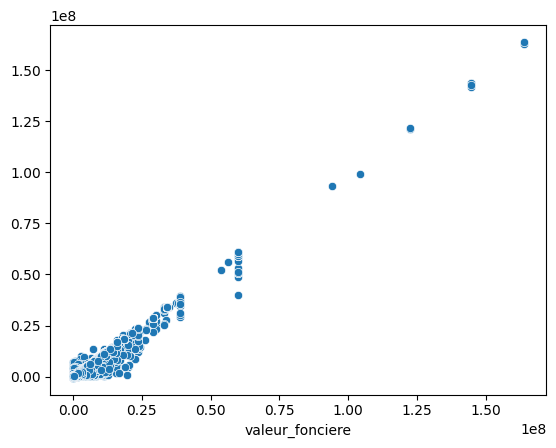

In [9]:
import seaborn as sns
y_pred = xgb_model.predict(X_train)
print("Mean Squared Error (MSE):", mean_squared_error(y_train, y_pred))
print("R2 Score:", r2_score(y_train, y_pred))
sns.scatterplot(x=y_train,y=y_pred)

Mean Squared Error (MSE): 118140270088.30031
R2 Score: 0.8978951040408009


<Axes: xlabel='valeur_fonciere'>

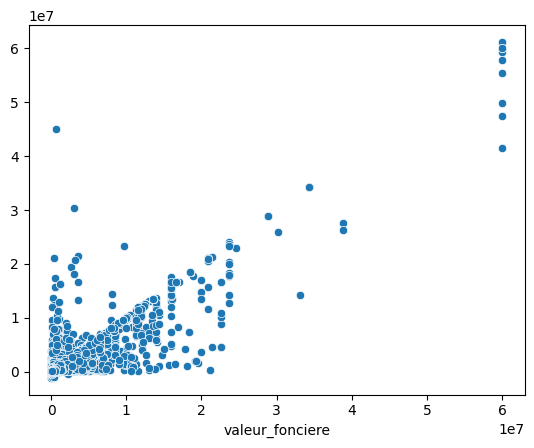

: 

In [ ]:
import seaborn as sns
y_pred = xgb_model.predict(X_test)
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))
sns.scatterplot(x=y_test,y=y_pred)

In [ ]:
# Test supplémentaire :
df_2 = data_loader(path,departements=[33,69,59,6,13])
X_2 = df_2
y_2= df_2['valeur_fonciere']
X_2 = pipeline_preprocess_train.fit_transform(X_2)
y_2 = X_2['valeur_fonciere']
X_2.drop(['valeur_fonciere'],axis=1,inplace=True)
y_pred_2 = xgb_model.predict(X_2)
print("Mean Squared Error (MSE):", mean_squared_error(y_2, y_pred_2))
print("R2 Score:", r2_score(y_2, y_pred_2))
sns.scatterplot(x=y_2,y=y_pred_2)